Data preprocessing :
<br>
INVESTIGATE MODEL PERFORMANCE BY NOT DROPPING ANY FEATURE<br>
Two data sources will be imported <br>
-"AIS_weather_h_rename_copy.csv" will be used to replace the information for true current direction and true wind direction <br>
-The resulting dataframe will be merged with the dataframe from the "AIS_weather_H_ok2_copy.csv" <br>
-The data of the journey between Ronne and Sassnitz will be omitted <br>
-The threshold for the ships manouvering speed will be 5kt (Abebe) <br>

In [34]:
import pandas as pd
from matplotlib import pyplot
import numpy as np
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime
import pickle
import joblib

dfmain = pd.read_csv("AIS_weather_H_ok2_copy.csv",parse_dates=["Time"])
dfmain = dfmain[dfmain['LAT'] > 55.04 ]

dfpre = pd.read_csv("AIS_weather_h_rename_copy.csv",parse_dates=["Time"])
dfpre = dfpre[dfpre['LAT'] > 55.04 ]



In [35]:
dfpre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7453 entries, 0 to 7995
Data columns (total 27 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Time                                  7453 non-null   datetime64[ns]
 1   LON                                   7453 non-null   float64       
 2   LAT                                   7453 non-null   float64       
 3   Eastward wind                         7453 non-null   float64       
 4   Northward wind                        7453 non-null   float64       
 5   Temperature above oceans              7453 non-null   float64       
 6   Air density above oceans              7337 non-null   float64       
 7   Max wave height                       6274 non-null   float64       
 8   Swell direction                       6274 non-null   float64       
 9   Wind wave direction                   6274 non-null   float64       
 10  

In [36]:
dfpre = dfpre.drop(dfpre.columns[[0,1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,21,22,23,26]],axis=1)
dfpre = dfpre.rename({'Eastward wind': 'eastwind', 'Northward wind': 'northwind',
                           'Eastward current': 'eastcurrent', 'Northward current': 'northcurrent',
                           'SOG':'sog','COG':'cog','Heading':'heading'},axis=1) 
dfpre.head(n=5)

,eastwind,northwind,eastcurrent,northcurrent,sog,cog
0,2.267688,6.741482,0.113690,0.044994,0.0,358.9
1,1.782681,6.410275,0.113690,0.044994,0.0,358.9
2,1.154659,6.385135,0.083984,0.054000,0.0,358.9
3,0.348801,6.094659,0.083984,0.054000,0.0,358.9
4,-0.593128,6.153186,0.083984,0.054000,0.0,358.9


In [37]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(dfpre)

KNNImputer(n_neighbors=50)

In [38]:
x_pre = imputer.transform(dfpre)

In [39]:
dfpre = pd.DataFrame(x_pre, columns=dfpre.columns, index=dfpre.index)

In [40]:
dfpre["Current Speed"] = np.sqrt(dfpre["eastcurrent"]**2 + dfpre["northcurrent"]**2)
dfpre["Wind Speed"] = np.sqrt(dfpre["eastwind"]**2 + dfpre["northwind"]**2)

In [41]:
dfpre["True North Wind Direction"] = 180 +  np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))

In [42]:
dfpre["True North Current Direction"] = np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))

In [43]:
dfpre.describe()

,eastwind,northwind,eastcurrent,northcurrent,sog,cog,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
count,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000
mean,1.976344,0.379926,0.019228,0.004214,8.870751,242.699284,0.096788,6.513813,186.323949,-0.733565
std,5.296850,4.429899,0.089903,0.074041,8.619512,108.555287,0.067697,3.048934,56.940496,57.865151
min,-15.216397,-12.824582,-0.491010,-0.404690,-0.009130,-0.134241,0.000735,0.193221,90.038520,-89.957853
25%,-1.756650,-2.534061,-0.021486,-0.033055,0.000000,124.116508,0.047447,4.149883,133.386049,-55.497208
50%,2.294543,0.385690,0.025485,0.003718,6.953578,283.216008,0.079148,6.285080,192.348882,-1.876044
75%,5.838650,3.339456,0.062644,0.039626,18.014436,346.200000,0.128444,8.525129,239.985376,54.717045
max,16.338177,14.519458,0.522374,0.364966,21.070514,359.728115,0.525174,16.760001,269.907884,89.975398


In [44]:
dfpre = dfpre.drop(['eastwind','northwind','eastcurrent','northcurrent','sog','cog'],axis=1)

In [45]:
dfmain = dfmain.drop(['Wind Speed','Current Speed'],axis=1)

In [46]:
df = pd.concat([dfmain,dfpre],axis=1)
df.head()

,Unnamed: 0,Time,LON,LAT,Temperature above oceans,Air density above oceans,Max wave height,Swell period,Wind wave period,Wave period,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
0,0,2021-01-01 00:00:00,14.689663,55.098452,277.311035,1.259323,1.893614,4.818881,3.818459,4.154329,...,174.0,155.408180,105.591753,22.854050,22.749664,22.610062,0.122270,7.112664,198.591820,68.408246
1,1,2021-01-01 01:00:00,14.689659,55.098451,277.328369,1.259985,1.752303,4.755800,3.470216,4.130580,...,174.0,158.458891,105.591753,26.122772,19.152008,22.209274,0.122270,6.653538,195.541109,68.408246
2,2,2021-01-01 02:00:00,14.689648,55.098468,277.390625,1.260244,1.619775,4.645083,3.259682,4.083755,...,174.0,163.749663,116.740448,28.498383,12.424912,20.857971,0.099846,6.488697,190.250337,57.259552
3,3,2021-01-01 03:00:00,14.689646,55.098471,277.411377,1.260148,1.518736,4.588384,3.177906,4.010502,...,174.0,170.724504,116.740448,29.956985,6.725922,18.732071,0.099846,6.104632,183.275496,57.259552
4,4,2021-01-01 04:00:00,14.689644,55.098462,277.430664,1.260634,1.455034,4.528841,3.281654,3.913362,...,174.0,179.505940,116.740448,34.486298,3.761627,15.731430,0.099846,6.181707,174.494060,57.259552


In [47]:
# SOG threshold according to Abebe
df = df[df['SOG'] > 5 ]

In [48]:
# Exclude data for the month of June to check the model's forecasting performance 
dfdate6 = df[df['Time'].dt.strftime('%Y-%m') == '2021-06']
df = df[df['Time'].dt.strftime('%Y-%m') != '2021-06']

In [49]:
# Temporary export
# df.to_csv("AIS_sog_threshold.csv")

In [50]:
# Temporary export
# df.to_csv("AIS_impute_check.csv")

Data Analysis before modelling 

In [51]:
# df_ship = df.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
#                     'Surface pressure','Width','Length'],axis=1)
# df_ship.head(n=5)

df_ship = df.drop(['Unnamed: 0','Time','LON','LAT'],axis=1)
df_ship.head(n=5)

,Temperature above oceans,Air density above oceans,Max wave height,Swell period,Wind wave period,Wave period,Sea surface temperature,Combined wind waves and swell height,Swell height,Wind wave height,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
8,276.900391,1.261916,1.661038,4.291309,3.667458,3.757862,279.699585,0.865413,0.323892,0.801956,...,269.900574,91.133175,143.029898,82.454986,91.138748,90.495209,0.104064,7.648595,181.033749,52.930471
9,276.705566,1.262235,1.501637,4.187211,3.145607,3.803910,279.820312,0.785675,0.452440,0.578049,...,300.130435,68.884377,96.351303,134.548587,115.015200,120.971331,0.104050,6.700397,189.014812,36.481737
10,276.309815,1.256282,1.235528,4.012717,2.120399,3.819602,NaN,0.654636,0.556525,0.236435,...,230.117302,129.989203,174.697284,59.296837,47.905998,52.498604,0.092759,4.089472,180.106505,44.814586
11,276.399902,1.256545,1.204397,4.020009,2.090308,3.820546,NaN,0.638782,0.555405,0.226181,...,178.653615,170.879672,107.951765,8.221531,10.314571,1.236454,0.093128,3.821501,187.773943,70.701850
12,277.134033,1.262830,1.275907,4.095175,3.029945,3.815268,279.820312,0.674081,0.598373,0.263031,...,125.446296,102.327505,72.665715,47.977150,68.470208,54.270195,0.086621,5.479353,203.118792,52.780582


In [52]:
# df_ship2 = df_ship.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
#                            'SOG': 'sog', 'Wind Speed': 'windspeed', 
#                            'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
#                            'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
#                             'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
#                             'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
#                             'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
#                             'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
#                             'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
#                            }, axis=1) 

In [53]:
# df_ship2 = df_ship2[['oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod','surftemp','windwaveswellheight','swellheight','windwaveheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]

In [54]:
# Scaling script if necessary

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# df_ship2 = pd.DataFrame(scaler.fit_transform(df_ship2),columns=df_ship2.columns)


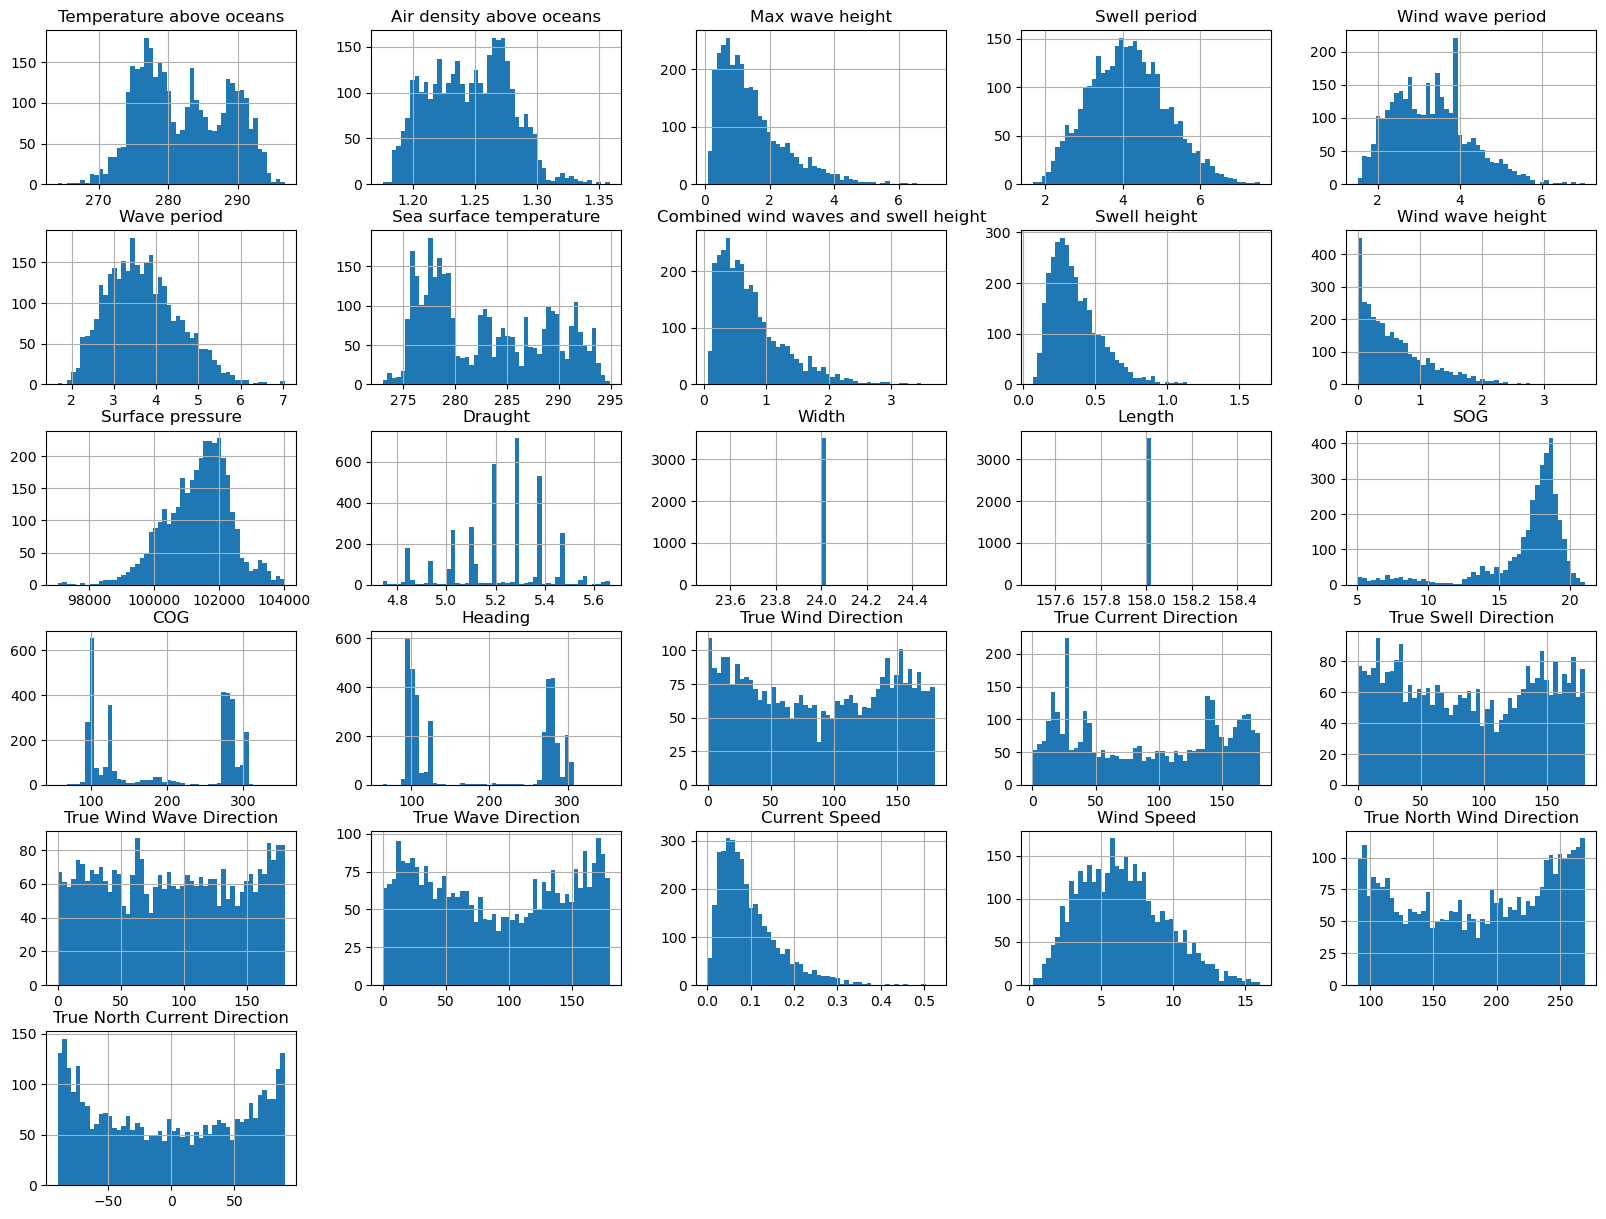

In [55]:
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
df_ship.hist(bins=50,figsize=(20,15))
plt.show()

In [56]:
# df_ship2['curspeed'].hist(bins=50)
# plt.show()

In [57]:
# hhstats = df_ship2.describe()
# print(hhstats)

Feature Selection

In [58]:
# corr_matrix = df_ship2.corr()
# print(corr_matrix["sog"])

In [59]:
# dfship_corr = df_ship2.drop(df_ship2.columns[[0,5,15,16,17,18,19,20,21]],axis=1)
# dfship_corr.head()

In [60]:
# def correlation_heatmap(df,fontsize):
#     correlations = df.corr()

#     fig, ax = plt.subplots(figsize=(10,10))
#     sns.set(font_scale = fontsize)
#     sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
#                 square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
#     plt.show();
    
# correlation_heatmap(df_ship2,0.5)

Scientific Justification of HCF:

According to Bitner Gregersen, the wind wave swell height is equal to the square root of the square of swell wave and wind wave. Therefore SWH and WWH is to be dropped.<br>
According to Mori, through wave spectrum, the maximum wave height can be approximated, therefore max wave height can be dropped as well <br>
According to Torsetshaugen, The type of dominating wave (Wind wave/Swell) can be predicted from the significant through an equation which include the significant wave height and a certain threshold, therefore, it is decided that the wind wave period, swell period and consequently the true wind wave direction and true swell direction is to be dropped.

In [61]:
# df_ship2 = df_ship2.drop(['waveheight','swellheight','windwaveheight',
#                         'windwaveperiod','swellperiod',
#                         'truewindwavedir','trueswelldir'],axis=1)
# correlation_heatmap(df_ship2,.6)

In [62]:
# dfship_corrftf = dfship_corr.drop(['waveheight','swellheight','windwaveheight'],axis=1)

# correlation_heatmap(dfship_corrftf,1)

In [63]:
# import matplotlib.pyplot as plt
# plt.rcParams.update(plt.rcParamsDefault)
# df_ship2.hist(bins=50,figsize=(20,15))
# plt.show()

In [64]:
# from pandas.plotting import scatter_matrix

# # attributes = df_ship2.columns

# scatter_matrix(dfship_corrftf,figsize=(25,25))

In [65]:
# df_ship2.info()

Imputing using KNN so that the Random Forest Regressor may function <br>
RFR cannot accept nan values <br>
Imputed data is then transformed

In [66]:
import numpy as np
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(df_ship)


KNNImputer(n_neighbors=50)

In [67]:
X = imputer.transform(df_ship)

In [68]:
df_shiptr = pd.DataFrame(X, columns=df_ship.columns, index=df_ship.index)

In [69]:
print(df_shiptr.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3506 entries, 8 to 7976
Data columns (total 26 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Temperature above oceans              3506 non-null   float64
 1   Air density above oceans              3506 non-null   float64
 2   Max wave height                       3506 non-null   float64
 3   Swell period                          3506 non-null   float64
 4   Wind wave period                      3506 non-null   float64
 5   Wave period                           3506 non-null   float64
 6   Sea surface temperature               3506 non-null   float64
 7   Combined wind waves and swell height  3506 non-null   float64
 8   Swell height                          3506 non-null   float64
 9   Wind wave height                      3506 non-null   float64
 10  Surface pressure                      3506 non-null   float64
 11  Draught          

Data Split for training and test data

In [72]:
# Implement the Random forest, but first, data is to be split into training and validation data

from sklearn.model_selection import train_test_split

# Dropping some feature can be done here to (possibly) increase the model's performance 

x_train,x_test,y_train,y_test = train_test_split(df_shiptr.drop(['SOG']
                                                                 ,axis=1)
                                                                ,df_shiptr.SOG,test_size=0.2,random_state=42)


In [73]:
print("Amount of the x training dataset is:",len(x_train))

Amount of the x training dataset is: 2804


In [74]:
print("Amount of the test dataset is",len(x_test))

Amount of the test dataset is 702


Modelling using Random Forest Regressor 

In [75]:
from sklearn.ensemble import RandomForestRegressor
model_rfr_ftr = RandomForestRegressor(random_state=42)
model_rfr_ftr.fit(x_train,y_train)

RandomForestRegressor(random_state=42)

In [76]:
from sklearn.ensemble import RandomForestRegressor
model_rfr_ftr_hpo = RandomForestRegressor(n_estimators=230,
                                  max_features=9,
                                  random_state=42, 
                                  )
model_rfr_ftr_hpo.fit(x_train,y_train)

RandomForestRegressor(max_features=9, n_estimators=230, random_state=42)

Modelling using Decision Tree Regressor

In [77]:
from sklearn.tree import DecisionTreeRegressor
model_dtr = DecisionTreeRegressor()
model_dtr.fit(x_train,y_train)

DecisionTreeRegressor()

Modelling using Multiple Linear Regression

In [78]:
from sklearn import linear_model
model_mlr = linear_model.LinearRegression()
model_mlr.fit(x_train,y_train)

LinearRegression()

Model Evaluation

In [79]:
from sklearn import tree

def tree_visualization(width,height,model_type):
    fn=x_train.columns
    fig, axes = plt.subplots(figsize = (width,height), dpi=800)
    tree.plot_tree(model_type.estimators_[0],
               max_depth=3,
               fontsize=8,
               feature_names = fn);
    plt.show()
    #fig.savefig('rf_individualtree.png')

tree_visualization(25,5,model_rfr_ftr_hpo)

In [80]:
def model_importance(model_type):
    mod_imp = model_type.feature_importances_
    df_mod_imp = pd.DataFrame(mod_imp,index= x_train.columns,columns=["Importance"])
    print(df_mod_imp)

model_importance(model_rfr_ftr_hpo)

                                      Importance
Temperature above oceans                0.006997
Air density above oceans                0.006581
Max wave height                         0.009731
Swell period                            0.007619
Wind wave period                        0.009075
Wave period                             0.006789
Sea surface temperature                 0.007184
Combined wind waves and swell height    0.007072
Swell height                            0.012184
Wind wave height                        0.014868
Surface pressure                        0.007649
Draught                                 0.023230
Width                                   0.000000
Length                                  0.000000
COG                                     0.396446
Heading                                 0.292370
True Wind Direction                     0.006398
True Current Direction                  0.072383
True Swell Direction                    0.014842
True Wind Wave Direc

Evaluation of RFR

In [81]:
def predict_y(x_test,model_type):
    y_predicted = model_type.predict(x_test)
    return y_predicted

def display_scores(x_test,y_test,model_type):
    from sklearn.metrics import explained_variance_score,mean_absolute_error,mean_squared_error,median_absolute_error
    y_predicted = model_type.predict(x_test)
    print("R^2 score (Indicate model fit. Best Score = 1):", model_type.score(x_test,y_test))
    print("Explained Variance EV (Indicate amount of variance in model. Best Score = 1):", explained_variance_score(y_test,y_predicted))
    print("Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0):", mean_absolute_error(y_test,y_predicted))
    print("Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0):", mean_squared_error(y_test,y_predicted))
    print("Median Absolute Error MAD (Check robustness against outlier. Best Score = 1):", median_absolute_error(y_test,y_predicted))

y_predicted = predict_y(x_test,model_rfr_ftr)
display_scores(x_test,y_test,model_rfr_ftr)


R^2 score (Indicate model fit. Best Score = 1): 0.935725072336701
Explained Variance EV (Indicate amount of variance in model. Best Score = 1): 0.9357836522440554
Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0): 0.5443618048939882
Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0): 0.6788462691274217
Median Absolute Error MAD (Check robustness against outlier. Best Score = 1): 0.3886875853999978


Evaluation of model with FTR + HPO

In [82]:
y_predicted = predict_y(x_test,model_rfr_ftr_hpo)
display_scores(x_test,y_test,model_rfr_ftr_hpo)

R^2 score (Indicate model fit. Best Score = 1): 0.9229403037625314
Explained Variance EV (Indicate amount of variance in model. Best Score = 1): 0.9232851012546784
Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0): 0.6174781837589064
Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0): 0.813873919313143
Median Absolute Error MAD (Check robustness against outlier. Best Score = 1): 0.44306885799565165


Evaluation of DTR

In [83]:
y_predicted = predict_y(x_test,model_dtr)
display_scores(x_test,y_test,model_dtr)

R^2 score (Indicate model fit. Best Score = 1): 0.833336729819593
Explained Variance EV (Indicate amount of variance in model. Best Score = 1): 0.8334806752380302
Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0): 0.866076017082621
Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0): 1.7602312950893768
Median Absolute Error MAD (Check robustness against outlier. Best Score = 1): 0.5848275949999984


Evaluation of MLR 

In [84]:
y_predicted = predict_y(x_test,model_mlr)
display_scores(x_test,y_test,model_mlr)

R^2 score (Indicate model fit. Best Score = 1): 0.6914685227025033
Explained Variance EV (Indicate amount of variance in model. Best Score = 1): 0.6917200974207507
Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0): 1.145130223645006
Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0): 3.25858697763064
Median Absolute Error MAD (Check robustness against outlier. Best Score = 1): 0.9070661049844242


In [85]:
cdf = pd.DataFrame(model_mlr.coef_, x_test.columns, columns=['Coefficients'])
print(cdf)

                                      Coefficients
Temperature above oceans              5.302920e-03
Air density above oceans             -7.847437e+00
Max wave height                      -5.074773e+00
Swell period                         -1.167201e-01
Wind wave period                     -3.010590e-02
Wave period                           6.169504e-01
Sea surface temperature              -4.422853e-02
Combined wind waves and swell height  9.482678e+00
Swell height                         -4.281442e-01
Wind wave height                     -6.063230e-01
Surface pressure                      1.849509e-04
Draught                               2.028925e+00
Width                                 4.595768e-13
Length                                1.554312e-15
COG                                  -1.146775e-01
Heading                               1.152823e-01
True Wind Direction                   3.536489e-04
True Current Direction               -2.732335e-04
True Swell Direction           

Saving model to local directory

In [120]:
# Saving the model to local directory

filename = 'savemodel_rfr_noftr.sav'
joblib.dump(model_rfr_ftr,filename)

filename = 'savemodel_dtr_noftr.sav'
joblib.dump(model_dtr,filename)


# filename = 'savemodel_rfr_ftr.sav'
# joblib.dump(model_rfr_ftr,filename)

# filename = 'savemodel_rfr_ftr_hpo.sav'
# joblib.dump(model_rfr_ftr_hpo,filename)

# filename = 'savemodel_dtr_ftr.sav'
# joblib.dump(model_dtr,filename)

# filename = 'savemodel_mlr_ftr.sav'
# joblib.dump(model_mlr,filename)

['savemodel_dtr_noftr.sav']

Hyperparameter Optimization

RFR

In [87]:
from pprint import pprint
pprint(model_rfr_ftr.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [88]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 21)]
# Number of features to consider at every split
max_features = [int(x) for x in np.linspace(1, 12, num = 11)]
# Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 200, num = 20)]
# max_depth.append(None)
max_depth = [None]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True],
 'max_depth': [None],
 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100,
                  110,
                  120,
                  130,
                  140,
                  150,
                  160,
                  170,
                  180,
                  190,
                  200,
                  210,
                  220,
                  230,
                  240,
                  250,
                  260,
                  270,
                  280,
                  290,
                  300]}


In [89]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
# rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = model_rfr_ftr, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42,n_jobs=-1)# Fit the random search model
rf_random.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [None],
                                        'max_features': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 12],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 110, 120, 130,
                                                         140, 150, 160, 170,
                                                         180, 190, 200, 210,
                                                         220, 230, 240, 250,
                                                         260, 270, 280, 290,
                                                         300]},
                   random_state=42, verbose=2)

In [90]:
rf_random.best_params_

{'n_estimators': 220,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 12,
 'max_depth': None,
 'bootstrap': True}

In [91]:
def evaluate(model, test_features, test_labels):
    from sklearn.metrics import explained_variance_score,mean_absolute_error,mean_squared_error,median_absolute_error

    predictions = model.predict(test_features)
    rsquared = model.score(test_features,test_labels)
    expVar = explained_variance_score(test_labels,predictions)
    MAE = mean_absolute_error(test_labels,predictions)
    MAD = median_absolute_error(test_labels,predictions)
    RMSE = np.sqrt(mean_squared_error(test_labels,predictions))

    print(f"Model Performance of {model}")
    print(f"R^2: {rsquared:0.4f}")
    print(f"explained Variance = {expVar:0.4f}")
    print(f"MAE = {MAE:0.4f}")
    print(f"RMSE = {RMSE:0.4f}")
    print(f"MAD = {MAD:0.4f}\n")
    
    return rsquared,expVar,MAE,RMSE,MAD

base_model = model_rfr_ftr
base_model.fit(x_train, y_train)
rsquared_base,expVar_base,MAE_base,RMSE_base,MAD_base = evaluate(base_model, x_test, y_test)

best_random = rf_random.best_estimator_
rsquared_random,expVar_random,MAE_random,RMSE_random,MAD_random = evaluate(best_random, x_test, y_test)
print('Improvement of Rsquared {:0.3f}%.'.format( 100 * (rsquared_random - rsquared_base) / rsquared_base))
print('Improvement of explainedVariance {:0.3f}%.'.format( 100 * (expVar_random - expVar_base) / expVar_base))
print('Improvement of MAE {:0.3f}%.'.format( 100 * (MAE_base - MAE_random) / MAE_base)) # MAE is other way around since best score is 0
print('Improvement of RMSE {:0.3f}%.'.format( 100 * (RMSE_base - RMSE_random) / RMSE_base)) # RMSE is other way around since best score is 0
print('Improvement of MAD {:0.3f}%.'.format( 100 * (MAD_base - MAD_random) / MAD_base)) # MAD is other way around since best score is 0

Model Performance of RandomForestRegressor(random_state=42)
R^2: 0.9357
explained Variance = 0.9358
MAE = 0.5444
RMSE = 0.8239
MAD = 0.3887

Model Performance of RandomForestRegressor(max_features=12, n_estimators=220, random_state=42)
R^2: 0.9294
explained Variance = 0.9296
MAE = 0.5823
RMSE = 0.8634
MAD = 0.4226

Improvement of Rsquared -0.673%.
Improvement of explainedVariance -0.656%.
Improvement of MAE -6.977%.
Improvement of RMSE -4.786%.
Improvement of MAD -8.732%.


DTR

In [92]:
# Number of trees in random forest
# Number of features to consider at every split
max_features = [int(x) for x in np.linspace(1, 12, num = 11)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 200, num = 20)]
max_depth.append(None)
# max_depth = [None]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
random_grid_dtr = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,}
pprint(random_grid_dtr)

{'max_depth': [10,
               20,
               30,
               40,
               50,
               60,
               70,
               80,
               90,
               100,
               110,
               120,
               130,
               140,
               150,
               160,
               170,
               180,
               190,
               200,
               None],
 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10]}


In [93]:
dt_random = RandomizedSearchCV(estimator = model_dtr, param_distributions = random_grid_dtr, n_iter = 100, cv = 5, verbose=2, random_state=42,n_jobs=-1)# Fit the dt search model
dt_random.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110, 120,
                                                      130, 140, 150, 160, 170,
                                                      180, 190, 200, None],
                                        'max_features': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 12],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   random_state=42, verbose=2)

In [94]:
dt_random.best_params_

{'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 12,
 'max_depth': 50}

In [119]:
base_model = model_dtr
base_model.fit(x_train, y_train)
rsquared_base,expVar_base,MAE_base,RMSE_base,MAD_base = evaluate(base_model, x_test, y_test)

best_random = dt_random.best_estimator_
rsquared_random,expVar_random,MAE_random,RMSE_random,MAD_random = evaluate(best_random, x_test, y_test)
print('Improvement of Rsquared {:0.3f}%.'.format( 100 * (rsquared_random - rsquared_base) / rsquared_base))
print('Improvement of explainedVariance {:0.3f}%.'.format( 100 * (expVar_random - expVar_base) / expVar_base))
print('Improvement of MAE {:0.3f}%.'.format( 100 * (MAE_base - MAE_random) / MAE_base)) # MAE is other way around since best score is 0
print('Improvement of RMSE {:0.3f}%.'.format( 100 * (RMSE_base - RMSE_random) / RMSE_base)) # RMSE is other way around since best score is 0
print('Improvement of MAD {:0.3f}%.'.format( 100 * (MAD_base - MAD_random) / MAD_base)) # MAD is other way around since best score is 0

Model Performance of DecisionTreeRegressor()
R^2: 0.8482
explained Variance = 0.8485
MAE = 0.8281
RMSE = 1.2661
MAD = 0.5844

Model Performance of DecisionTreeRegressor(max_depth=50, max_features=12, min_samples_leaf=4,
                      min_samples_split=10)
R^2: 0.8167
explained Variance = 0.8168
MAE = 0.8612
RMSE = 1.3914
MAD = 0.5453

Improvement of Rsquared -3.715%.
Improvement of explainedVariance -3.740%.
Improvement of MAE -3.994%.
Improvement of RMSE -9.892%.
Improvement of MAD 6.690%.


In [96]:
# def evaluate(model, test_features, test_labels):
#     predictions = model.predict(test_features)
#     errors = abs(predictions - test_labels)
#     mape = 100 * np.mean(errors / test_labels)
#     accuracy = 100 - mape
#     print('Model Performance')
#     print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
#     print('Accuracy = {:0.2f}%.'.format(accuracy))
    
#     return accuracy

# base_model = model_rfr_ftr
# base_model.fit(x_test, y_test)
# base_accuracy = evaluate(base_model, x_test, y_test)
# best_random = rf_random.best_estimator_
# random_accuracy = evaluate(best_random, x_test, y_test)
# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [97]:
# from sklearn.model_selection import GridSearchCV# Create the parameter grid based on the results of random search 
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 230, stop = 240, num = 10)]
# # Number of features to consider at every split
# max_features = [9]
# # Maximum number of levels in tree
# max_depth = [None]
# # Minimum number of samples required to split a node
# min_samples_split = [2]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1]
# # Method of selecting samples for training each tree
# bootstrap = [True]# Create the random grid
# param_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# pprint(param_grid)
# # Create a based model

# grid_search = GridSearchCV(estimator = model_rfr_ftr, param_grid = param_grid, 
#                           cv = 3, n_jobs = -1, verbose = 2)

Use GridSearch

In [98]:
# # Fit the grid search to the data
# grid_search.fit(x_train, y_train)
# grid_search.best_params_

In [99]:
# best_grid = grid_search.best_estimator_
# grid_accuracy = evaluate(best_grid, x_test, y_test)

In [100]:
# print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Forecasting for June 2021

In [101]:
# dfdate6 = dfdate6.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
# 'Surface pressure','Width','Length'],axis=1)
# dfdate6.head(n=5)

In [102]:
# dfdate6= dfdate6.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
#                            'SOG': 'sog', 'Wind Speed': 'windspeed', 
#                            'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
#                            'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
#                             'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
#                             'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
#                             'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
#                             'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
#                             'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
#                            }, axis=1) 

In [103]:
# import numpy as np
# from sklearn.impute import KNNImputer

# imputer = KNNImputer(n_neighbors=50)

In [104]:
# imputer.fit(dfdate6)

In [105]:
# xdate = imputer.transform(dfdate6)

In [106]:
# dfdate6tr = pd.DataFrame(xdate, columns=dfdate6.columns, index=dfdate6.index)

In [107]:
# x_date = dfdate6tr.drop(['sog','truenorthcurrentdir','truenorthwinddir'],axis=1)
# y_date = dfdate6tr.sog

In [108]:
# y_predicted = predict_y(x_date,model_rfr)
# display_scores(x_date,y_date,model_rfr)


In [109]:
# display_scores(x_date,y_date,model_dtr)


In [110]:
# ydate_pred = y_predicted
# dfprog_sog = pd.Series(y_date,name="sog_act").to_frame()
# dfprog_sog["sog_pred"] = ydate_pred
# dfprog_sog["gamma"] = dfdate6tr["truenorthcurrentdir"]
# dfprog_sog["truenorthwinddir"] = dfdate6tr["truenorthwinddir"]

# print(dfprog_sog)

In [111]:
# dfprog = pd.concat([x_date,dfprog_sog],axis=1)
# dfprog.head(n=10)

In [112]:
# dfprog["vgms"] = dfprog["sog_pred"]/1.9438

In [113]:
# rad_gamma = np.deg2rad(dfprog["gamma"])
# rad_cog = np.deg2rad(dfprog["cog"])

In [114]:
# dfprog["vgx"] = dfprog["vgms"] * np.sin(rad_cog)
# dfprog["vcx"] = dfprog["curspeed"] * np.sin(rad_gamma)
# dfprog["stw_x"] = (dfprog["vgx"] - dfprog["vcx"])

In [115]:
# dfprog["vgy"] = dfprog["vgms"] * np.cos(rad_cog)
# dfprog["vcy"] = dfprog["curspeed"] * np.cos(rad_gamma)
# dfprog["stw_y"] = (dfprog["vgy"] - dfprog["vcy"])

In [116]:
# dfprog["vwms_p"] = np.sqrt(dfprog["stw_x"]**2 + dfprog["stw_y"]**2)
# dfprog["stw_pred"] = dfprog["vwms_p"]*1.9438
# dfprog = dfprog.drop(['vgms','vgx','vcx','stw_x',
#                       'vgy','vcy','stw_y',
#                       'vwms_p'],axis=1)
# #df_ship.head(n=5)
# dfprog.head(n=10)

In [117]:
# dfprog.describe()